In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

# configure jupyter to display Matplot in high-resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# getting stocks data from quandl
# selecting stocks for portfolio

quandl.ApiConfig.api_key = '67Hm_ER7zQVJcasmWSKN'
stocks = ['AMD', 'ATVI', 'INTC', 'EA']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = {'columns': ['date', 'ticker', 'adj_close']},
                        date = {'gte': '2016-01-01', 'lte': '2021-06-30'}, paginate = True)
# check data
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-27,INTC,51.19
1,2018-03-26,INTC,52.48
2,2018-03-23,INTC,49.36
3,2018-03-22,INTC,50.83
4,2018-03-21,INTC,51.56


In [5]:
# set the index to date
df = data.set_index('date')
df.head()

,ticker,adj_close
date,,
2018-03-27,INTC,51.19
2018-03-26,INTC,52.48
2018-03-23,INTC,49.36
2018-03-22,INTC,50.83
2018-03-21,INTC,51.56


In [6]:
# set column headers to tickers
# Pandas pivot, returns reshaped DataFrame organized by given index
table = df.pivot(columns='ticker')
table.columns = [col[1] for col in table.columns]
table.head()

,AMD,ATVI,EA,INTC
date,,,,
2016-01-04,2.770,37.094471,66.10,31.810946
2016-01-05,2.750,36.621176,64.94,31.661204
2016-01-06,2.505,36.276065,63.68,30.959285
2016-01-07,2.275,35.763330,62.46,29.798780
2016-01-08,2.140,35.211152,63.13,29.489936


Text(0, 0.5, 'price in $')

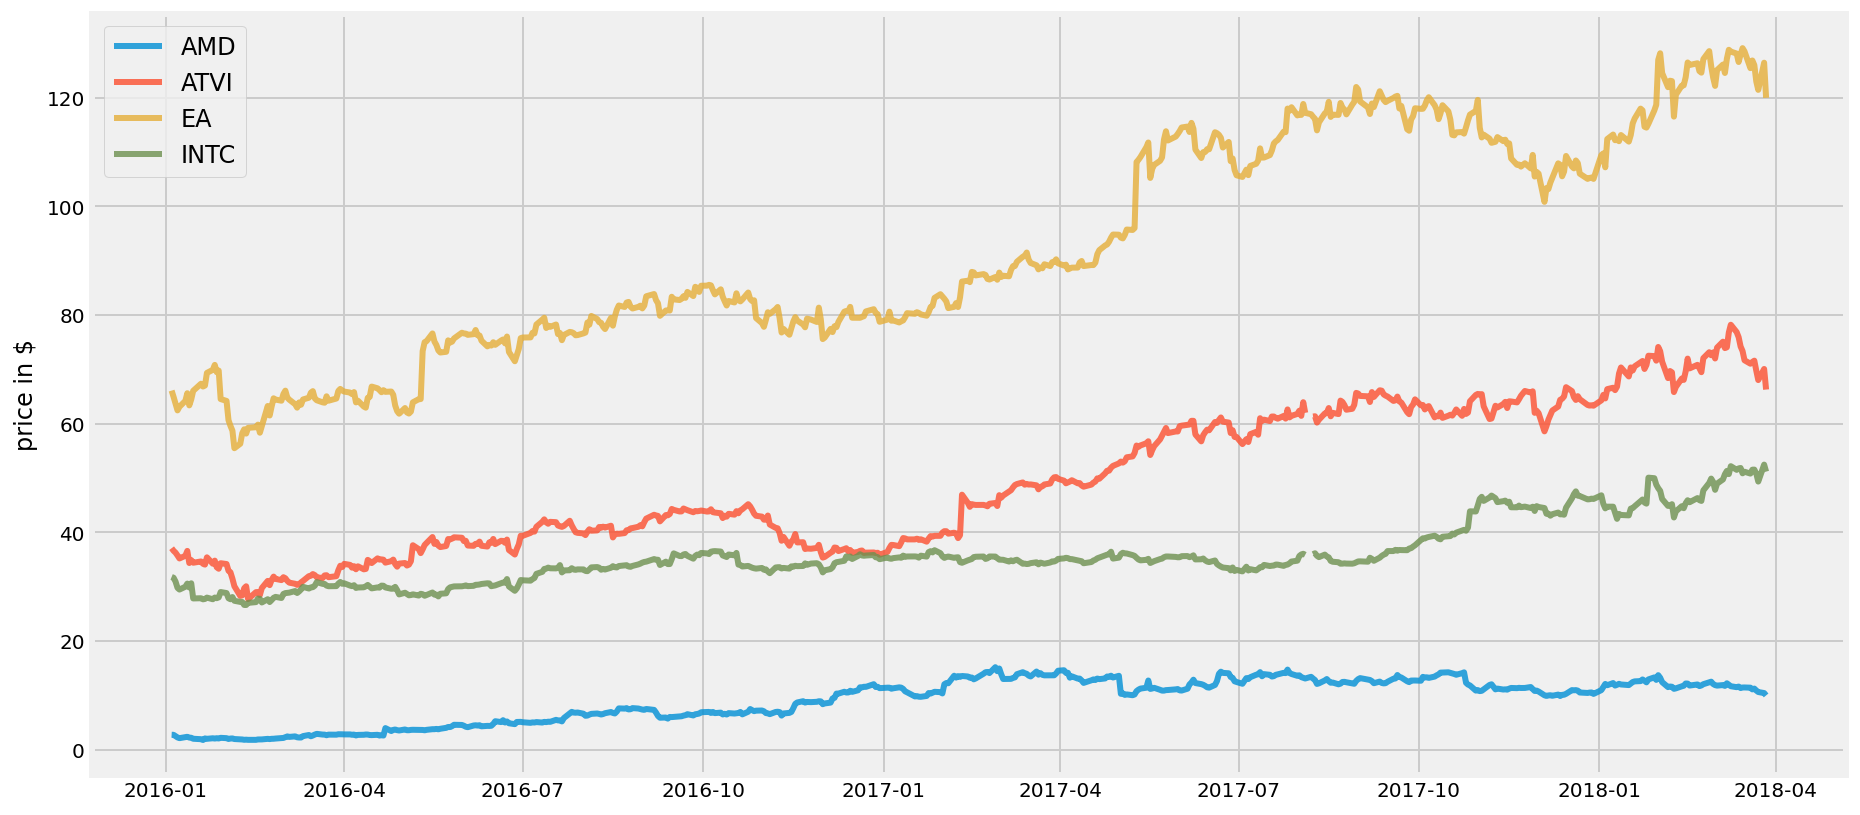

In [7]:
# analyze stock prices overtime
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

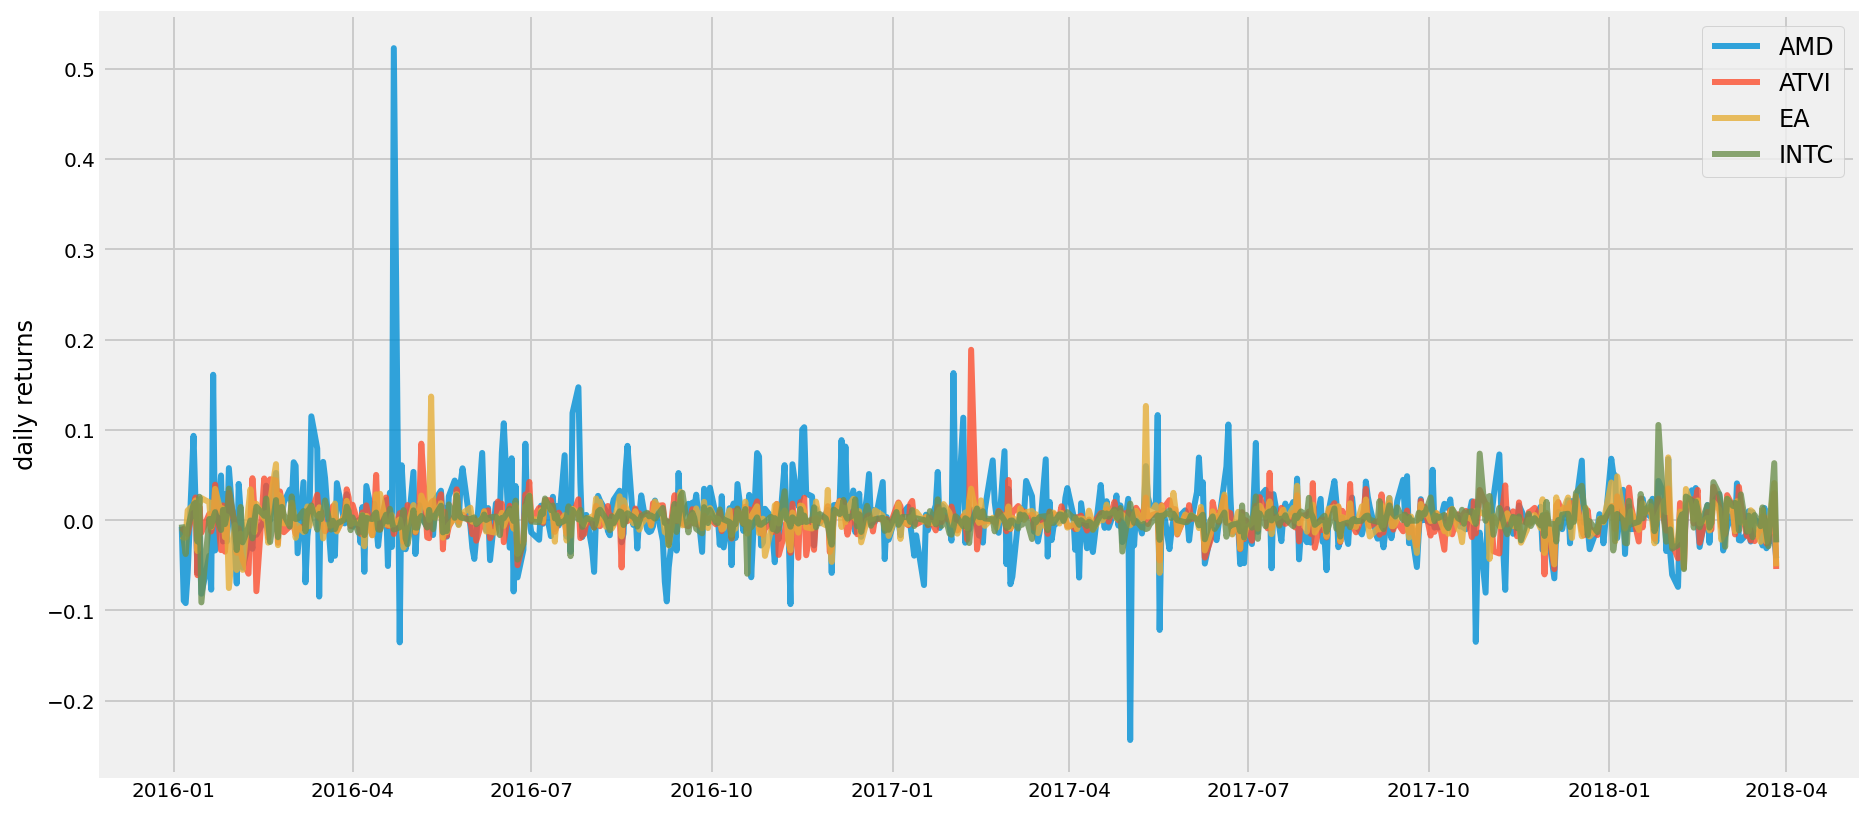

In [8]:
# percentage change analysis
returns = table.pct_change()

plt.figure(figsize=(14,7))
for c in table.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [9]:
def portfolio_annual_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [14]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annual_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [15]:
# inputs for above variables
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 2000
risk_free_rate = 0.0178

In [16]:
def simulate_ef(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns,cov_matrix,risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=table.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
       
    print("-"*80)
    print("Max Sharpe Ratio Portfolio Allocation\n")
    print("Annual Return:", round(rp,2))
    print("Annual Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Min Volatility Portfolio Allocation\n")
    print("Annual Return:", round(rp_min,2))
    print("Annual Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu',marker='o',s=10,alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Max Sharpe Ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Min Volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annual volatility')
    plt.ylabel('annual returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Max Sharpe Ratio Portfolio Allocation

Annual Return: 0.38
Annual Volatility: 0.24


              AMD  ATVI     EA   INTC
allocation  18.68  12.0  31.76  37.56
--------------------------------------------------------------------------------
Min Volatility Portfolio Allocation

Annual Return: 0.28
Annual Volatility: 0.2


             AMD   ATVI     EA   INTC
allocation  1.29  14.86  28.78  55.06


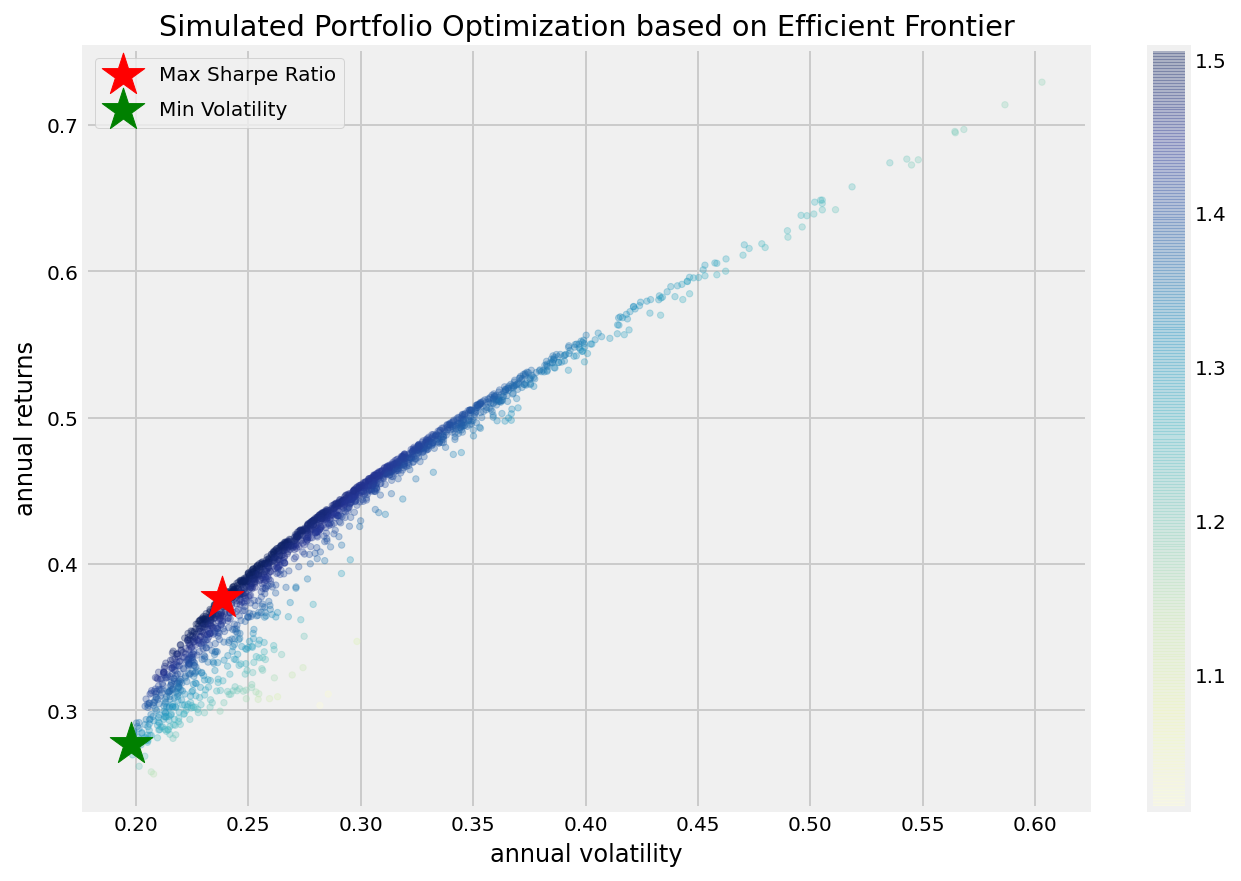

In [17]:
simulate_ef(mean_returns, cov_matrix, num_portfolios, risk_free_rate)